# Naive Bayesian on Amazon Fine Food Reviews dataset

## Text to Vector algorithms used:-
### Bag of Words
### Tf-idf

### Importing necessary libraries

In [3]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from tqdm import tqdm
import os
from imblearn.over_sampling import SMOTE

In [4]:
#Loading the dataset
con = sqlite3.connect("../input/amazon-fine-food-reviews/database.sqlite")
filtered = pd.read_sql_query("select * from Reviews where Score != 3",con)
filtered.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Cleaning the dataset

In [5]:
#Sorting the filtered dataset according to product id
filtered_sort = filtered.sort_values("ProductId", axis = 0, ascending = True)
#Removing duplicate datasets keeping only one of them
filtered = filtered_sort.drop_duplicates(subset = {"UserId","ProfileName","Time","Text"}, keep = 'first', inplace = False)
print("Shape after dropping duplicates = ", filtered.shape)
#Dropping those rows where HelpFulnessNumerator > HelpFullnessDenominator
filtered = filtered[filtered.HelpfulnessNumerator <= filtered.HelpfulnessDenominator]
print("Shape after removing HelpFulnessNumerator > HelpFullnessDenominator rows = ",filtered.shape)

Shape after dropping duplicates =  (364173, 10)
Shape after removing HelpFulnessNumerator > HelpFullnessDenominator rows =  (364171, 10)


In [6]:
#Changing scores as either "negative" if score<3 or "positive" if score>3
def polarity(score):
    if score < 3:
        return 0
    else:
        return 1

l = filtered['Score']
pos_neg = l.map(polarity)
filtered['Score'] = pos_neg
filtered.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


In [ ]:
#Taking out only Text, Time and Score columns in another dataframe
df = filtered[['Text','Time','Score']]
df.shape
counts = df['Score'].value_counts()
print(counts)
print("Ratio of positive reviews:- ",counts[1]/(counts[0]+counts[1]))
print("Ratio of negative points:- ",counts[0]/(counts[0]+counts[1]))

## Text cleaning

In [ ]:
#Text Cleaning
import string
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
#Text cleaning
def cleantext(review):
    cleanr = re.compile('<.*?>')
    text = re.sub(cleanr," ",review)
    text = re.sub('[^a-zA-Z]',' ',text)
    return text
corpus = []
for review in tqdm(df['Text']):
    st = cleantext(review)
    st = st.lower()
    st = st.split()
    sn = SnowballStemmer('english')
    st = [sn.stem(word) for word in st if not word in set(stopwords.words('english'))]
    st = ' '.join(st)
    corpus.append(st)

In [ ]:

df['Text'] = corpus
#Sorting the values according to time for time based splitting
df = df.sort_values('Time',axis=0,ascending=True)
df = df.reset_index(drop=True)
df.head()
#df.to_csv("corpus.csv",index = False)

## Loading the already prepared corpus file.

In [7]:
df = pd.read_csv("../input/amazon-fine-food-corpus/corpus.csv")
print(df.head())
df['Score'].value_counts()

                                                Text       Time  Score
0  witti littl book make son laugh loud recit car...  939340800      1
1  grew read sendak book watch realli rosi movi i...  940809600      1
2  fun way children learn month year learn poem t...  944092800      1
3  great littl book read aloud nice rhythm well g...  944438400      1
4  book poetri month year goe month cute littl po...  946857600      1


1    307061
0     57110
Name: Score, dtype: int64

### Since dataset is large so taking only 100K datapoints

In [8]:
df1k = df.loc[0:99999,:]
print("Shape of the new dataframe:- ",df1k.shape)
df1k['Score'].value_counts()

Shape of the new dataframe:-  (100000, 3)


1    87729
0    12271
Name: Score, dtype: int64

## Time based splitting train , cross validation and test dataset

In [9]:
from sklearn.model_selection import TimeSeriesSplit
def timeseries(x,y):
    ts = TimeSeriesSplit(n_splits=4)
    for train_index,test_index in ts.split(x):
        x_train,x_test = x[train_index],x[test_index]
        y_train,y_test = y[train_index],y[test_index]
    return x_train,x_test,y_train,y_test

x_train,x_test,y_train,y_test = timeseries(df1k['Text'].values,df1k['Score'].values)

## Function for feature importance
### This function will return top ten important features decided by the model.

In [21]:
def imp_feature(model,classifier):
    neg = classifier.feature_log_prob_[0,:].argsort()
    pos = classifier.feature_log_prob_[1,:].argsort()
    top_pos_words = np.take(model.get_feature_names(),pos)
    top_neg_words = np.take(model.get_feature_names(),neg)
    imp_df = pd.DataFrame(columns = ['Pos_Words','Pos_Importance','Neg_Words','Neg_Importance'])
    imp_df['Pos_Words'] = top_pos_words[::-1]
    imp_df['Pos_Importance'] = np.take(classifier.feature_log_prob_[1,:],pos)[::-1]
    imp_df['Neg_Words'] = top_neg_words[::-1]
    imp_df['Neg_Importance'] = np.take(classifier.feature_log_prob_[0,:],neg)[::-1]
    return imp_df

## Bag of Words Vectorizer

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
bow_train = cv.fit_transform(x_train)
print("Bag of words train vector shape:- ",bow_train.shape)

Bag of words train vector shape:-  (80000, 34646)


## Oversampling on the training data
### Since the dataset is highly imblanced so applying oversampling to make the number of class 0 equal to class 1.

In [12]:
%%time
print("Count of 1 before oversampling:- ",sum(y_train==1))
print("Count of 0 before oversampling:- ",sum(y_train==0))
sm = SMOTE(random_state = 0)
bow_train_ov,y_train_ov = sm.fit_sample(bow_train,y_train)
print("Count of 1 after oversampling:- ",sum(y_train_ov==1))
print("Count of 0 after oversampling:- ",sum(y_train_ov==0))
print("Shape of x_train data after oversampling:- ",bow_train_ov.shape)
print("Shape of y_train data after oversampling:- ",y_train_ov.shape)

Count of 1 before oversampling:-  70404
Count of 0 before oversampling:-  9596
Count of 1 after oversampling:-  70404
Count of 0 after oversampling:-  70404
Shape of x_train data after oversampling:-  (140808, 34646)
Shape of y_train data after oversampling:-  (140808,)
CPU times: user 53 s, sys: 3.92 s, total: 57 s
Wall time: 56.9 s


### Using GridSearchCV for hyperparameter tuning of Naive Bayes

In [13]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
param_grid = {'alpha':list(np.arange(0.1,10,0.5))}
gs = GridSearchCV(mnb,param_grid,scoring = 'f1',cv = 5,n_jobs = -1)
gs.fit(bow_train_ov,y_train_ov)
print("Best value of alpha:- ",gs.best_params_)
print("Best score:- ",gs.best_score_)

Best value of alpha:-  {'alpha': 7.1}
Best score:-  0.7804748445329236
CPU times: user 528 ms, sys: 324 ms, total: 852 ms
Wall time: 16.9 s


#### I have choosen Multnomial version of Naive Bayes since i am using Bag of Words with its binary parameter set as False which means each vector is having count of words(only integer) in the respective sentence  which matches with Multinomial distribution.

### Testing the Naive Bayesian model with optimal alpha value on test data

In [14]:
%%time
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
bow_test = cv.transform(x_test)
mnb = MultinomialNB(alpha = 7.1)
mnb.fit(bow_train_ov,y_train_ov)
y_pred_log = mnb.predict_log_proba(bow_test) # predicting log prob. of test data
print("Log probabilities:- ",y_pred_log)
y_pred1 = np.exp(y_pred_log) # Converting log_prob. to normal prob.(0to1)
print("Normal Probabilties:- ",y_pred1)
y_pred = np.zeros(len(y_test))
for i,p in enumerate(y_pred1[:,0]): # Converting the prob. to 0 or 1 values.
    if p > 0.5:
        y_pred[i] = 0
    else:
        y_pred[i] = 1
f1 = f1_score(y_test,y_pred)
print("BOW test f1_Score:- ",(f1*100))
test_acc = accuracy_score(y_test,y_pred)
print("BOW Test accuracy:- ",(test_acc*100))

Log probabilities:-  [[-5.54374844e+00 -3.91950729e-03]
 [-2.34652450e+00 -1.00595436e-01]
 [-1.03608748e+01 -3.16472592e-05]
 ...
 [-2.82772972e+00 -6.09683487e-02]
 [-5.39410578e+00 -4.55363335e-03]
 [-3.70445852e+00 -2.49215188e-02]]
Normal Probabilties:-  [[3.91183605e-03 9.96088164e-01]
 [9.57011948e-02 9.04298805e-01]
 [3.16467585e-05 9.99968353e-01]
 ...
 [5.91469815e-02 9.40853019e-01]
 [4.54328128e-03 9.95456719e-01]
 [2.46135415e-02 9.75386459e-01]]
BOW test f1_Score:-  90.13025082270954
BOW Test accuracy:-  82.155
CPU times: user 832 ms, sys: 20 ms, total: 852 ms
Wall time: 851 ms


### Error Plot

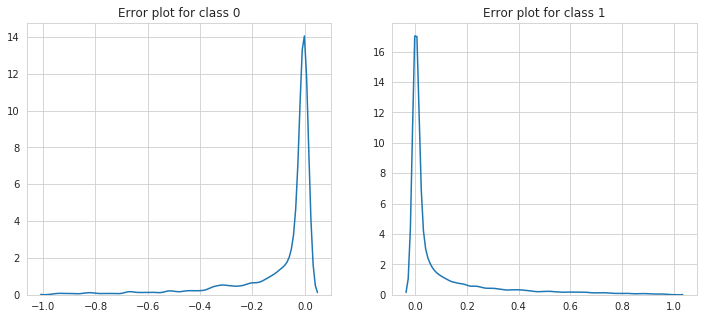

In [19]:
sns.set_style("whitegrid")
plt.figure(1,figsize = (12,5))
plt.subplot(121)
delta0 = y_test[y_test == 0] - y_pred1[y_test==0,0]
sns.kdeplot(np.array(delta0))
plt.title("Error plot for class 0")
plt.subplot(122)
delta1 = y_test[y_test == 1] - y_pred1[y_test==1,1]
sns.kdeplot(np.array(delta1))
plt.title("Error plot for class 1")
plt.show()

#### The above error plots' mean is at 0 with very less variance which indicates model has done good predictions with very less errors.

In [16]:
%%time
#Training error and test error
y_train_pred = mnb.predict(bow_train)
bow_train_error = 1 - accuracy_score(y_train,y_train_pred)
print("Training accuracy:- ",(1-bow_train_error)*100)
bow_test_error = 1 - test_acc
print("Test accuracy:- ",test_acc*100)

Training accuracy:-  83.33749999999999
Test accuracy:-  82.155
CPU times: user 40 ms, sys: 52 ms, total: 92 ms
Wall time: 33.2 ms


### Feature importance

In [27]:
x = imp_feature(cv,mnb)
print("Feature importance of the words in each class")
x

Feature importance of the words in each class


,Pos_Words,Pos_Importance,Neg_Words,Neg_Importance
0,like,-4.581801,tea,-3.880962
1,tea,-4.623151,like,-4.181844
2,tast,-4.633735,tast,-4.186519
3,use,-4.808671,good,-4.399580
4,good,-4.821426,love,-4.414309
5,product,-4.874773,great,-4.432715
6,love,-4.880697,product,-4.469261
7,one,-4.882389,flavor,-4.542748
8,great,-4.910479,use,-4.555937
9,flavor,-4.914962,one,-4.679286


[[  135  2540]
 [ 1029 16296]]


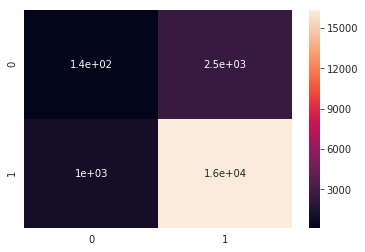

In [25]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
print(cm)
#Plotting confusion matrix
sns.heatmap(cm, annot = True)

### ===============================================================================

## Tfidf Vectorizer implementation

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf = True)
tfidf_train = tfidf.fit_transform(x_train)
print("Shape of tfidf_train:- ",tfidf_train.shape)

Shape of tfidf_train:-  (80000, 34646)


### Using GridSearchCV to find the optimal alpha

In [47]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB(class_prior=(1,1))
param_grid = {'alpha':list(np.arange(0.1,5,0.2))}
gs = GridSearchCV(mnb,param_grid,scoring = 'neg_log_loss',cv = 5,n_jobs = -1)
gs.fit(tfidf_train,y_train)
print("Best value of alpha:- ",gs.best_params_)
print("Best score:- ",gs.best_score_)

Best value of alpha:-  {'alpha': 1.5000000000000004}
Best score:-  -0.4201678774495166
CPU times: user 368 ms, sys: 124 ms, total: 492 ms
Wall time: 7.17 s


#### Tfidf results in fractional/decimal numbers in the vectors which does not belong to Multinomial distribution. But as specified in the sklearn documentation that practically it has been seen that Tfidf vectorizer works pretty good with the MultinomialNB. Hence i am continuing with MultinomailNB in Tfidf implementation also.

### Testing the Naive Bayesian model with optimal alpha value on test data

In [48]:
%%time
tfidf_test = tfidf.transform(x_test)
mnb = MultinomialNB(alpha = 1.5, class_prior=(1,1))
mnb.fit(tfidf_train,y_train)
y_pred_log = mnb.predict_log_proba(tfidf_test) # predicting log prob. of test data
print("Log probabilities:- ",y_pred_log)
y_pred1 = np.exp(y_pred_log) # Converting log_prob to normal prob.(0to1)
print("Normal Probabilties:- ",y_pred1)
y_pred = np.zeros(len(y_test))
for i,p in enumerate(y_pred1[:,0]): # Converting the prob. to 0 or 1 values.
    if p > 0.5:
        y_pred[i] = 0
    else:
        y_pred[i] = 1
f1 = f1_score(y_test,y_pred)
print("Tfidf test f1_Score:- ",(f1*100))
test_acc = accuracy_score(y_test,y_pred)
print("Tfidf Test accuracy:- ",(test_acc*100))

Log probabilities:-  [[-1.82893117 -0.17505019]
 [-1.97812362 -0.14888123]
 [-2.67020321 -0.07175184]
 ...
 [-1.70353573 -0.20094031]
 [-2.71706212 -0.06835226]
 [-1.71078138 -0.19933489]]
Normal Probabilties:-  [[0.16058511 0.83941489]
 [0.13832855 0.86167145]
 [0.06923815 0.93076185]
 ...
 [0.18203874 0.81796126]
 [0.06606857 0.93393143]
 [0.18072452 0.81927548]]
Tfidf test f1_Score:-  92.58761556654483
Tfidf Test accuracy:-  86.21
CPU times: user 856 ms, sys: 8 ms, total: 864 ms
Wall time: 862 ms


### Error Plot

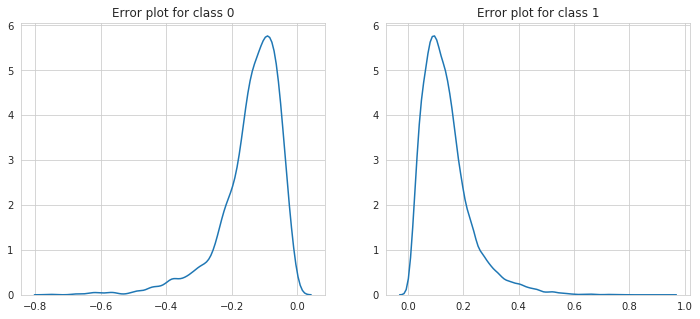

In [49]:
sns.set_style("whitegrid")
plt.figure(1,figsize = (12,5))
plt.subplot(121)
delta0 = y_test[y_test == 0] - y_pred1[y_test==0,0]
sns.kdeplot(np.array(delta0))
plt.title("Error plot for class 0")
plt.subplot(122)
delta1 = y_test[y_test == 1] - y_pred1[y_test==1,1]
sns.kdeplot(np.array(delta1))
plt.title("Error plot for class 1")
plt.show()

In [50]:
%%time
#Training error and test error
y_train_pred = mnb.predict(tfidf_train)
tfidf_train_error = 1 - accuracy_score(y_train,y_train_pred)
print("Training accuracy:- ",(1-tfidf_train_error)*100)
tfidf_test_error = 1 - test_acc
print("Test accuracy:- ",test_acc*100)

Training accuracy:-  87.46374999999999
Test accuracy:-  86.21
CPU times: user 20 ms, sys: 4 ms, total: 24 ms
Wall time: 24.7 ms


### Feature Importance

In [51]:
x = imp_feature(tfidf,mnb)
print("Feature importance of each class")
x

Feature importance of each class


,Pos_Words,Pos_Importance,Neg_Words,Neg_Importance
0,tast,-5.320930,tast,-5.923018
1,great,-5.354869,love,-5.947382
2,love,-5.355869,great,-5.955995
3,like,-5.370234,like,-5.979470
4,tea,-5.385084,tea,-5.983950
5,good,-5.392862,good,-6.000408
6,product,-5.445521,product,-6.036236
7,flavor,-5.525810,flavor,-6.114059
8,use,-5.530797,use,-6.144731
9,one,-5.599745,one,-6.176716


[[   17  2658]
 [  100 17225]]


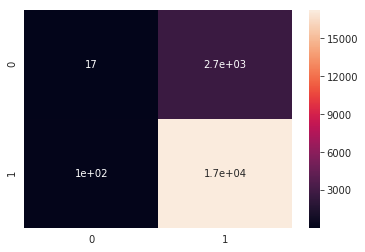

In [52]:
#Confusion matrix
cm = confusion_matrix(y_test,y_pred)
print(cm)
#Plotting confusion matrix
sns.heatmap(cm,annot= True)

### ================================================================================

## Conclusion:-

| Vectorizer | Hyperparameter(alpha) | Training Accuracy | Test Accuracy |
| - | - | - | - |
| Bag of Words | 7.1 | 83.33 | 82.15 |
|Tfidf | 1.39 | 87.46 | 86.21 |

### ================================================================================